In [1]:
from adversarial_lab.core import ALModel
from adversarial_lab.core.noise_generators import AdditiveNoiseGenerator
from adversarial_lab.attacks.whitebox import WhiteBoxMisclassification
from adversarial_lab.core.preprocessing import PreprocessingFromFunction
from adversarial_lab.utils.plotting import plot_images_and_noise
from adversarial_lab.arsenal import CarliniWagnerAttack, ProjectedGradientDescentAttack

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [2]:
model = InceptionV3(weights='imagenet')

def preprocess(data, *args, **kwargs):
    input = tf.cast(data, dtype=tf.float32)
    if len(input.shape) == 2:
        input = tf.expand_dims(input, axis=-1)
        input = tf.image.grayscale_to_rgb(input)

    elif len(input.shape) == 3 and input.shape[-1] == 1:
        input = tf.image.grayscale_to_rgb(input)

    input_tensor = tf.convert_to_tensor(input, dtype=tf.float32)
    resized_image = tf.image.resize(input_tensor, (299, 299))
    batch_image = tf.expand_dims(resized_image, axis=0)
    return preprocess_input(batch_image)

pp = PreprocessingFromFunction.create(preprocess)

In [3]:
image = Image.open('data/panda.jpg')
image_array = np.array(image)

np.argmax(model.predict(pp.preprocess(image_array)), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([388], dtype=int64)

In [4]:
from adversarial_lab.analytics import AdversarialAnalytics, ImageTracker, LossTracker, PredictionsTracker
from adversarial_lab.db.sqllite import SqlliteDB

db = SqlliteDB(db_path="whitebox.db")
analytics = AdversarialAnalytics(db, 
                                 [
                                     LossTracker(track_batch=False), 
                                 ], 
                                 "test", 
                                 True)

In [5]:
attacker = ProjectedGradientDescentAttack(model=model, preprocessing_fn=pp, learning_rate=0.01, C=5, kappa=15, analytics=analytics, epsilon=0.2)

In [6]:
noise = attacker.attack(image_array, target_class=257, target_vector=None, strategy="random", verbose=3, epochs=500)

Attacking:   1%|          | 4/500 [00:03<06:56,  1.19it/s, Loss=3.15, Prediction=257, Prediction Confidence=0.675]

In [7]:
np.max(noise[0])

0.04

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.04..1.04].


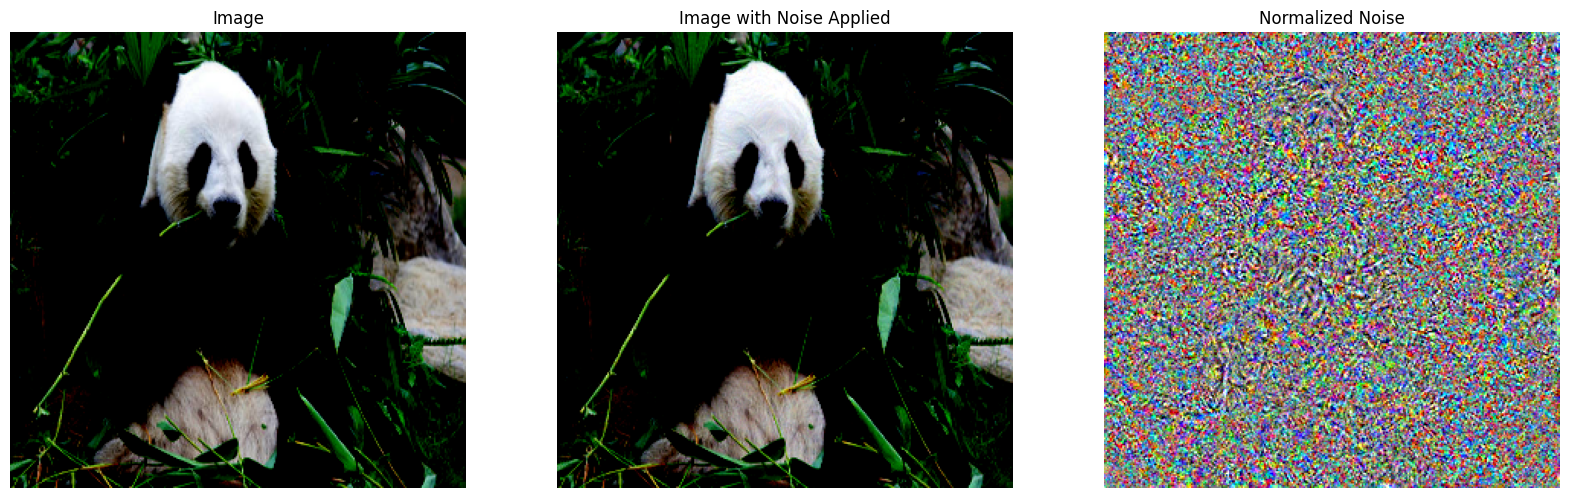

In [8]:
plot_images_and_noise(pp.preprocess(image_array), noise[0])


In [9]:
np.max(noise[0])

0.04